Script to analyse and plot RESTING MEMBRANE POTENTIAL (RMP)

In [4]:
import pyabf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [2]:
"""

Script to extract resting membrane potential (RMP) from ABF files and add it to an existing Excel file (file with all the results)
Use this to recalculate the RMP values for all cells in the database.
Otherwise plot existing 

"""
def extract_rmp_from_abf(abf_file):
    """
    Extract resting membrane potential from an ABF file by averaging 
    the first 100ms of each sweep, then averaging across all sweeps.
    """
    abf = pyabf.ABF(abf_file)
    sweep_rmp_values = []
    sweep_indices = abf.sweepList[-10:] if len(abf.sweepList) > 10 else abf.sweepList

    for sweep in sweep_indices:
        abf.setSweep(sweep)  # Set the current sweep
        first_100ms = abf.sweepY[:int(0.1 * abf.dataRate)]  # First 100 ms
        sweep_rmp_values.append(np.mean(first_100ms))  # Calculate mean for the sweep
    
    # Average across all sweeps
    rmp = np.mean(sweep_rmp_values)
    return rmp

def add_rmp_to_excel(csv_file_path):
    """
    Add RMP column to existing Excel file by processing each ABF file.
    """
    # Load the existing results file
    results_df = pd.read_excel(csv_file_path)
    
    # Add new column for RMP if it doesn't exist
    if 'RMP' not in results_df.columns:
        results_df['RMP'] = None
    
    # Process each row to calculate RMP
    for i, row in results_df.iterrows():
        if pd.notna(row['filepath']) and os.path.exists(row['filepath']):
            print(f"Processing file {i+1}/{len(results_df)}: {row['filepath']}")
            
            try:
                rmp = extract_rmp_from_abf(abf_file=row['filepath'])
                # Update the specific row
                results_df.at[i, 'RMP'] = rmp
            except Exception as e:
                print(f"Error processing {row['filepath']}: {e}")
                results_df.at[i, 'RMP'] = None
        else:
            # Handle missing files
            results_df.at[i, 'RMP'] = None
            print(f"File not found: {row.get('filepath', 'N/A')}")

    # Save back to the same file
    results_df.to_excel(csv_file_path, index=False)
    print(f"Updated Excel file saved with new 'RMP' column")
    
    # Filter and display summary
    filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
    print(f"Number of cells after filtering: {len(filtered_df)}")

In [ ]:
def plot_rmp(results_df):
    """
    Plot resting membrane potential (RMP) by condition for each genotype.
    """
    genotypes = results_df['genotype'].unique()
    conditions = ['baseline', 'Noradrenaline', 'wash']
    colors = ['lightgrey', 'lightcoral', 'lightblue']
    
    fig, axes = plt.subplots(1, len(genotypes), figsize=(8, 5), sharey=True)
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        group = results_df[results_df['genotype'] == genotype]

        if group.empty:
            continue
        
        # Create jittered x positions
        jitter_amount = 0.1
        np.random.seed(42)
        
        # Plot each cell as a line across conditions
        for _, row in group.iterrows():
            y = [row[cond] for cond in conditions if pd.notna(row[cond])]
            
            # Only plot if we have data for all conditions
            if len(y) == len(conditions):
                x_jittered = [i + np.random.uniform(-jitter_amount, jitter_amount) for i in range(len(conditions))]
                
                ax.plot(x_jittered, y, color='lightgray', alpha=0.8, linewidth=1)
                ax.scatter(x_jittered, y, color=colors, s=60, zorder=3, edgecolors='black', linewidths=0.7)
        
        # Plot means
        for i, cond in enumerate(conditions):
            y_vals = group[cond].dropna().values
            if len(y_vals) > 0:
                ax.hlines(np.mean(y_vals), i - 0.15, i + 0.15, color='black', linewidth=5)
        
        ax.set_xticks(range(len(conditions)))
        ax.set_xticklabels(['baseline', 'NA', 'wash'], rotation=45)
        ax.set_title(f"{genotype}", fontsize=12)
        ax.set_xlim(-0.5, len(conditions) - 0.5)
    
    # Set y-label only on the leftmost plot - FIXED LABEL
    axes[0].set_ylabel("Resting Membrane Potential (mV)")
    plt.tight_layout()
    plt.show()


def plot_rmp_boxplot_grouped(results_df):
    """
    Plot resting membrane potential (RMP) as grouped boxplots with genotypes on x-axis.
    Each genotype shows all conditions side by side for easy comparison.
    """
    conditions = ['baseline', 'Noradrenaline', 'wash']
    genotypes = results_df['genotype'].unique()
    
    # Prepare data for grouped boxplot
    data_for_plot = []
    for _, row in results_df.iterrows():
        for condition in conditions:
            if pd.notna(row[condition]):
                data_for_plot.append({
                    'condition': condition,
                    'genotype': row['genotype'],
                    'RMP': row[condition]
                })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(data_for_plot)
    
    if plot_df.empty:
        print("No data to plot")
        return
    
    plt.figure(figsize=(8, 6))
    
    # Create boxplot with hue for condition grouping
    ax = sns.boxplot(
        data=plot_df,
        x='genotype',          # Changed: genotype on x-axis
        y='RMP',
        hue='condition',       # Changed: condition as hue (grouping)
        palette=['lightgray', 'lightcoral', 'lightblue'],  # Colors for conditions
        width=0.6,
        showfliers=False,
        boxprops={"alpha": 0.8}
    )
    
    # Overlay individual data points
    sns.stripplot(
        data=plot_df,
        x='genotype',        
        y='RMP',
        hue='condition',       
        palette=["#908E8E", "#EB6F6F", "#56CAFF"], 
        size=4,
        jitter=True,
        alpha=0.8,
        dodge=True  # This separates the points by condition
    )

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Customize the plot
    plt.xlabel("Genotype", fontsize=12)
    plt.ylabel("Resting Membrane Potential (mV)", fontsize=12)
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.show()


In [9]:
results_csv = "C:\\Users\\rbondare\\ephys\\results\\all_peak_results_final.xlsx"
results_df = pd.read_excel(results_csv)
print("Columns in results_df:", results_df.columns.tolist())
print(results_df.head())

# Exclude rows where comment is "exclude"
filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
print("number of cells after filtering:", len(filtered_df))

# Create pivot table for RMP data
pivot = filtered_df.pivot_table(
    index=['ID', 'genotype'],
    columns='condition',
    values='RMP'
).reset_index()

print("Pivot table shape:", pivot.shape)
print("Pivot columns:", pivot.columns.tolist())
print(pivot.head())



Columns in results_df: ['filepath', 'filename', 'condition', 'genotype', 'ID', 'total_sweeps', 'normalized_first_peak', 'selected_10sweeps_first', 'normalized_all_peaks', 'selected_10sweeps_all', 'firingRate_10sweeps_all', 'comment', 'RMP']
                                            filepath             filename  \
0  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0002.abf   
1  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0003.abf   
2  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0004.abf   
3  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0007.abf   
4  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0008.abf   

       condition    genotype  ID  total_sweeps  normalized_first_peak  \
0       baseline  eGFP-Gad67   1            18                    1.0   
1  Noradrenaline  eGFP-Gad67   1            32                    1.0   
2           wash  eGFP-Gad67   1            42                    1.0   
3   

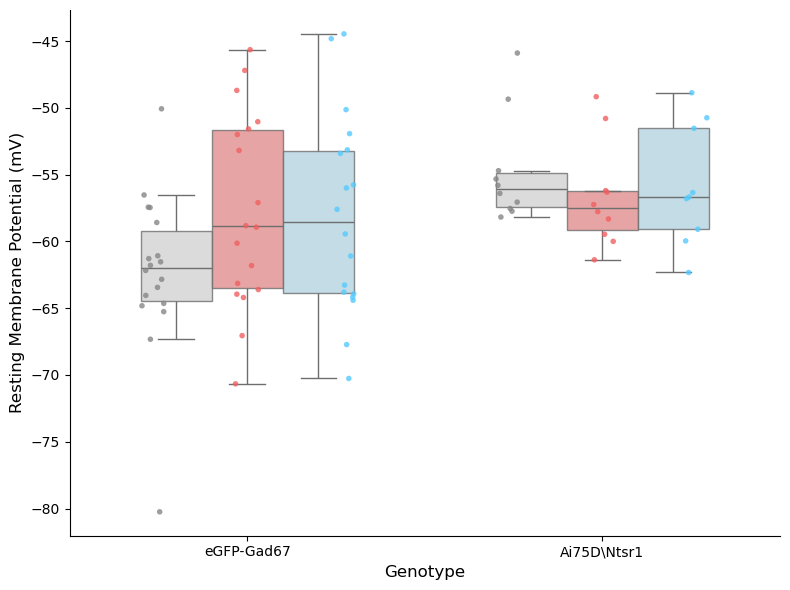

In [14]:
plot_rmp_boxplot_grouped(pivot)

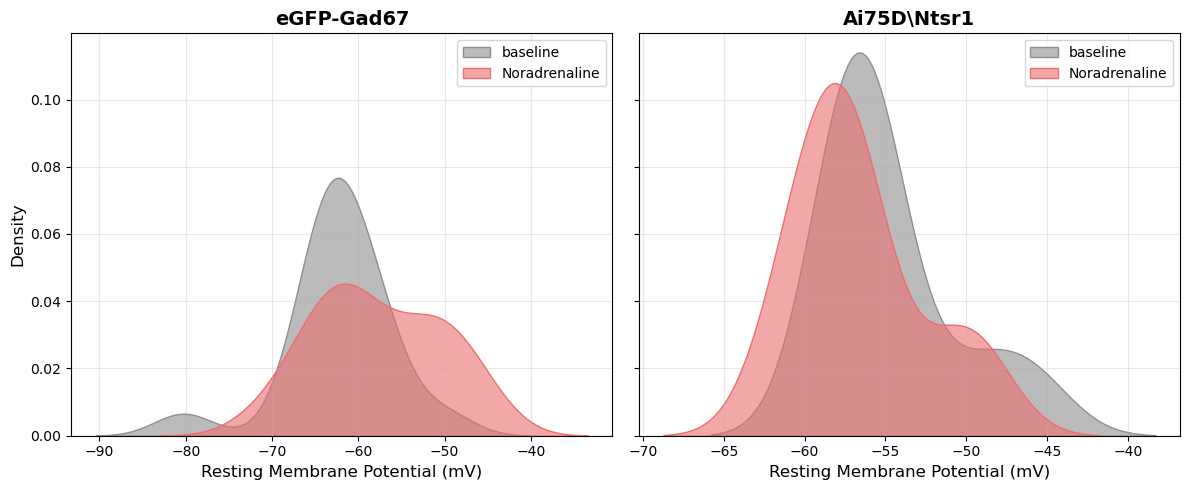

In [15]:
def plot_rmp_histogram_by_genotype(results_df):
    """
    Plot RMP histograms with separate subplots for each genotype.
    Each subplot shows overlapping histograms for the 3 conditions.
    """
    conditions = ['baseline', 'Noradrenaline', 'wash']
    genotypes = results_df['genotype'].unique()
    
    # Prepare data for histogram
    data_for_plot = []
    for _, row in results_df.iterrows():
        for condition in conditions:
            if pd.notna(row[condition]):
                data_for_plot.append({
                    'condition': condition,
                    'genotype': row['genotype'],
                    'RMP': row[condition]
                })
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(data_for_plot)
    
    if plot_df.empty:
        print("No data to plot")
        return
    
    # Create subplots - one for each genotype
    fig, axes = plt.subplots(1, len(genotypes), figsize=(12, 5), sharey=True)
    
    # Handle case where there's only one genotype
    if len(genotypes) == 1:
        axes = [axes]
    
    # Color palette for conditions
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        genotype_data = plot_df[plot_df['genotype'] == genotype]
        
        # Plot histogram for each condition
        for i, condition in enumerate(conditions):
            condition_data = genotype_data[genotype_data['condition'] == condition]['RMP']
            
            if len(condition_data) > 0:
                ax.hist(condition_data, 
                       bins=8, 
                       alpha=0.7, 
                       label=condition,
                       color=colors[i],
                       edgecolor='black',
                       linewidth=0.5)
        
        ax.set_title(f"{genotype}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Resting Membrane Potential (mV)", fontsize=12)
        if idx == 0:  # Only show y-label on leftmost plot
            ax.set_ylabel("Frequency", fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




def plot_rmp_density(results_df):
    """
    Density plots instead of histograms for smoother visualization
    """
    conditions = ['baseline', 'Noradrenaline']
    genotypes = results_df['genotype'].unique()
    
    # Prepare data
    data_for_plot = []
    for _, row in results_df.iterrows():
        for condition in conditions:
            if pd.notna(row[condition]):
                data_for_plot.append({
                    'condition': condition,
                    'genotype': row['genotype'],
                    'RMP': row[condition]
                })
    
    plot_df = pd.DataFrame(data_for_plot)
    
    if plot_df.empty:
        print("No data to plot")
        return
    
    fig, axes = plt.subplots(1, len(genotypes), figsize=(12, 5), sharey=True)
    
    if len(genotypes) == 1:
        axes = [axes]


    colors = ["#908E8E", "#EB6F6F"] 
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        genotype_data = plot_df[plot_df['genotype'] == genotype]
        
        # Plot density for each condition
        for i, condition in enumerate(conditions):
            condition_data = genotype_data[genotype_data['condition'] == condition]
            
            if len(condition_data) > 0:
                sns.kdeplot(data=condition_data, 
                           x='RMP',
                           label=condition,
                           color=colors[i],
                           fill=True,
                           alpha=0.6,
                           ax=ax)
        
        ax.set_title(f"{genotype}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Resting Membrane Potential (mV)", fontsize=12)
        if idx == 0:
            ax.set_ylabel("Density", fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_rmp_density(pivot)

Processing file 1/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0002.abf
Processing file 2/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0003.abf
Processing file 3/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0004.abf
Processing file 4/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0007.abf
Processing file 5/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0008.abf
Processing file 6/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0009.abf
Processing file 7/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0012.abf
Processing file 8/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0013.abf
Processing file 9/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0014.abf
Processing file 13/84: Z:\Group Members\Rima\Ephys_NE\DATA\gad\25.03.2025 M2\2025_03_25_0012.abf
Processing file 14/84: Z:\Group Members

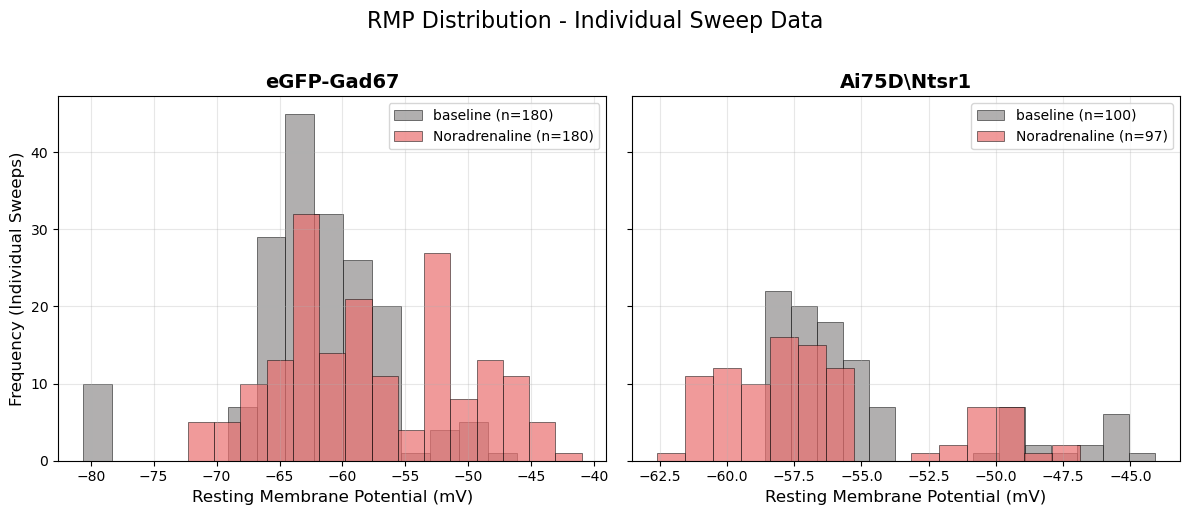

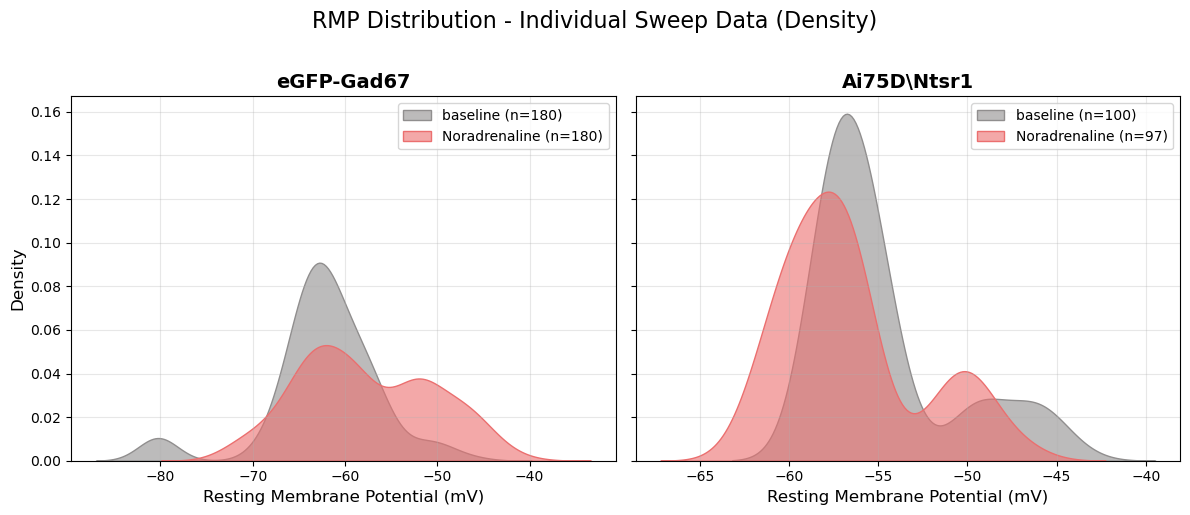

In [17]:
def extract_rmp_per_sweep(abf_file):
    """
    Extract resting membrane potential from each individual sweep in an ABF file.
    Returns a list of RMP values, one per sweep.
    """
    try:
        abf = pyabf.ABF(abf_file)
        sweep_rmp_values = []
        
        # Use last 10 sweeps (or all if fewer than 10)
        sweep_indices = abf.sweepList[-10:] if len(abf.sweepList) > 10 else abf.sweepList
        
        for sweep in sweep_indices:
            abf.setSweep(sweep)
            first_100ms = abf.sweepY[:int(0.1 * abf.dataRate)]  # First 100 ms
            sweep_rmp = np.mean(first_100ms)
            sweep_rmp_values.append(sweep_rmp)
        
        return sweep_rmp_values
    
    except Exception as e:
        print(f"Error processing {abf_file}: {e}")
        return []

def create_rmp_per_sweep_dataframe(csv_file_path):
    """
    Create a dataframe with RMP values for each individual sweep.
    """
    # Load the existing results file
    results_df = pd.read_excel(csv_file_path)
    
    # Filter out excluded files
    filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
    
    # Create list to store all sweep data
    all_sweep_data = []
    
    # Process each file
    for i, row in filtered_df.iterrows():
        if pd.notna(row['filepath']) and os.path.exists(row['filepath']):
            print(f"Processing file {i+1}/{len(filtered_df)}: {row['filepath']}")
            
            # Extract RMP from each sweep
            sweep_rmp_values = extract_rmp_per_sweep(row['filepath'])
            
            # Add each sweep as a separate row
            for sweep_idx, rmp_value in enumerate(sweep_rmp_values):
                all_sweep_data.append({
                    'ID': row['ID'],
                    'genotype': row['genotype'],
                    'condition': row['condition'],
                    'sweep_number': sweep_idx + 1,
                    'RMP': rmp_value,
                    'filepath': row['filepath']
                })
        else:
            print(f"File not found: {row.get('filepath', 'N/A')}")
    
    # Convert to DataFrame
    sweep_df = pd.DataFrame(all_sweep_data)
    
    print(f"Created dataframe with {len(sweep_df)} individual sweep measurements")
    print(f"From {len(filtered_df)} cells across {len(sweep_df['genotype'].unique())} genotypes")
    
    return sweep_df

def plot_rmp_histogram_per_sweep(sweep_df):
    """
    Plot RMP histograms using individual sweep data.
    Each subplot shows overlapping histograms for the 3 conditions.
    """
    conditions = ['baseline', 'Noradrenaline']
    genotypes = sweep_df['genotype'].unique()
    
    # Create subplots - one for each genotype
    fig, axes = plt.subplots(1, len(genotypes), figsize=(12, 5), sharey=True)

    # Color palette for conditions
    colors = ["#908E8E", "#EB6F6F"]  
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        genotype_data = sweep_df[sweep_df['genotype'] == genotype]
        
        # Plot histogram for each condition
        for i, condition in enumerate(conditions):
            condition_data = genotype_data[genotype_data['condition'] == condition]['RMP']
            
            if len(condition_data) > 0:
                ax.hist(condition_data, 
                       bins=15,  # More bins since we have more data points
                       alpha=0.7, 
                       label=f"{condition} (n={len(condition_data)})",
                       color=colors[i],
                       edgecolor='black',
                       linewidth=0.5)
        
        ax.set_title(f"{genotype}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Resting Membrane Potential (mV)", fontsize=12)
        if idx == 0:  # Only show y-label on leftmost plot
            ax.set_ylabel("Frequency (Individual Sweeps)", fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("RMP Distribution - Individual Sweep Data", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_rmp_density_per_sweep(sweep_df):
    """
    Density plots using individual sweep data for smoother visualization
    """
    conditions = ['baseline', 'Noradrenaline']
    genotypes = sweep_df['genotype'].unique()
    
    fig, axes = plt.subplots(1, len(genotypes), figsize=(12, 5), sharey=True)
    
    if len(genotypes) == 1:
        axes = [axes]
    
    colors = ["#908E8E", "#EB6F6F"] 
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        genotype_data = sweep_df[sweep_df['genotype'] == genotype]
        
        # Plot density for each condition
        for i, condition in enumerate(conditions):
            condition_data = genotype_data[genotype_data['condition'] == condition]
            
            if len(condition_data) > 0:
                sns.kdeplot(data=condition_data, 
                           x='RMP',
                           label=f"{condition} (n={len(condition_data)})",
                           color=colors[i],
                           fill=True,
                           alpha=0.6,
                           ax=ax)
        
        ax.set_title(f"{genotype}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Resting Membrane Potential (mV)", fontsize=12)
        if idx == 0:
            ax.set_ylabel("Density", fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("RMP Distribution - Individual Sweep Data (Density)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Usage example:
results_csv = "C:\\Users\\rbondare\\ephys\\results\\all_peak_results_final.xlsx"

# Create dataframe with individual sweep data
sweep_df = create_rmp_per_sweep_dataframe(results_csv)

# Display some info about the data
print("\nDataframe info:")
print(sweep_df.head())
print(f"\nData summary:")
print(sweep_df.groupby(['genotype', 'condition']).agg({
    'RMP': ['count', 'mean', 'std'],
    'ID': 'nunique'
}).round(2))

# Plot histograms
plot_rmp_histogram_per_sweep(sweep_df)

# Plot density plots
plot_rmp_density_per_sweep(sweep_df)

C:\Users\rbondare\AppData\Local\Temp\ipykernel_29024\1676764718.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


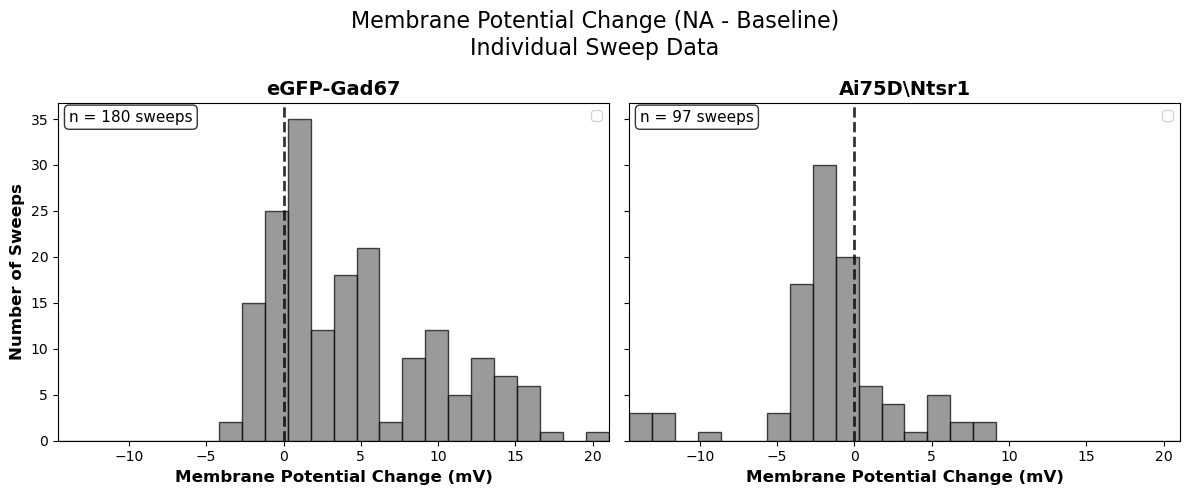

In [19]:
# Plot histogram of membrane potential change using individual sweep data
from scipy import stats

def plot_delta_rmp_per_sweep_histogram(sweep_df):
    """
    Plot histogram of membrane potential change (Noradrenaline - baseline) 
    using individual sweep data for each genotype, with centered x-axes.
    Uses the same sweep extraction basis as the existing functions.
    """
    genotypes = sweep_df['genotype'].unique()
    conditions = ['baseline', 'Noradrenaline']
    
    # First, calculate all delta values to determine common x-axis range
    all_deltas = []
    genotype_deltas = {}
    
    for genotype in genotypes:
        genotype_data = sweep_df[sweep_df['genotype'] == genotype]
        cell_deltas = []
        
        # For each cell, calculate delta for each sweep
        for cell_id in genotype_data['ID'].unique():
            cell_data = genotype_data[genotype_data['ID'] == cell_id]
            
            baseline_sweeps = cell_data[cell_data['condition'] == 'baseline']['RMP'].values
            na_sweeps = cell_data[cell_data['condition'] == 'Noradrenaline']['RMP'].values
            
            # Calculate mean baseline and mean NA for this cell, then delta
            if len(baseline_sweeps) > 0 and len(na_sweeps) > 0:
                baseline_mean = np.mean(baseline_sweeps)
                # For each NA sweep, calculate delta from baseline mean
                for na_val in na_sweeps:
                    delta = na_val - baseline_mean
                    cell_deltas.append(delta)
        
        genotype_deltas[genotype] = cell_deltas
        all_deltas.extend(cell_deltas)
    
    # Determine common x-axis range for centering
    if all_deltas:
        x_min = min(all_deltas) - 1
        x_max = max(all_deltas) + 1
        bins = np.linspace(x_min, x_max, 25)
    else:
        print("No data to plot")
        return
    
    # Create subplots - one for each genotype
    fig, axes = plt.subplots(1, len(genotypes), figsize=(12, 5), sharey=True)
    
    if len(genotypes) == 1:
        axes = [axes]
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        delta_data = genotype_deltas[genotype]
        
        if len(delta_data) > 0:
            # Plot histogram
            ax.hist(delta_data, bins=bins, color="#707070", edgecolor='black', 
                   alpha=0.7, density=False)
            
            # Add vertical line at zero (centered)
            ax.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.8)
            
            # Add sample size to plot
            ax.text(0.02, 0.98, f'n = {len(delta_data)} sweeps', 
                   transform=ax.transAxes, fontsize=11, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
            
            ax.set_title(f"{genotype}", fontsize=14, fontweight='bold')
            ax.set_xlabel("Membrane Potential Change (mV)", fontsize=12, fontweight='bold')
            ax.legend()
            # ax.grid(True, alpha=0.3)
            
            # Set same x-axis range for all plots (centered)
            ax.set_xlim(x_min, x_max)
            
    # Set y-label only on leftmost plot
    axes[0].set_ylabel("Number of Sweeps", fontsize=12, fontweight='bold')
    
    plt.suptitle("Membrane Potential Change (NA - Baseline)\nIndividual Sweep Data", 
                 fontsize=16)
    plt.tight_layout()
    plt.show()

plot_delta_rmp_per_sweep_histogram(sweep_df)

C:\Users\rbondare\AppData\Local\Temp\ipykernel_29024\3832934995.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


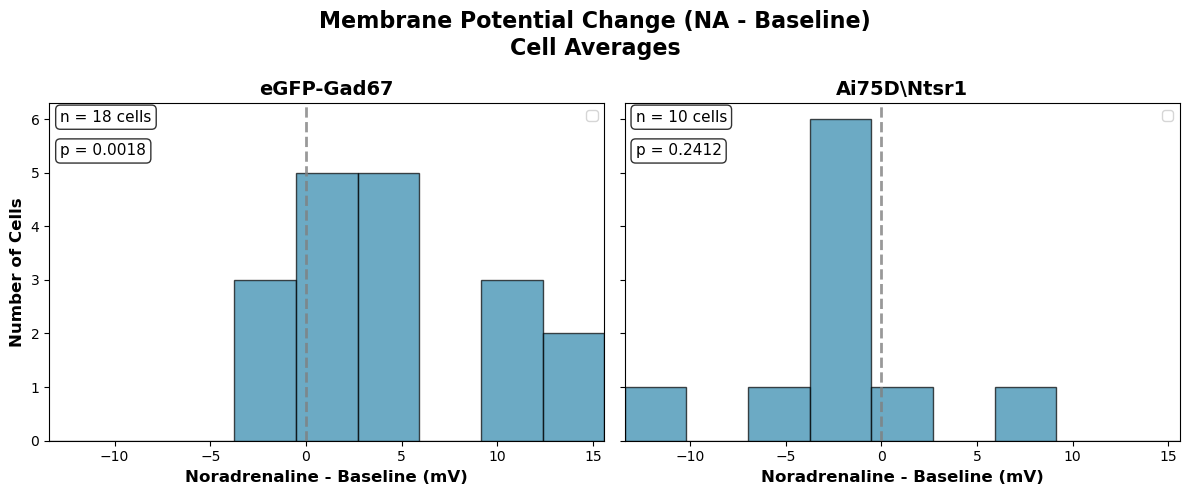

In [24]:
# Plot histogram of membrane potential change using cell averages
from scipy import stats

def plot_delta_rmp_cell_averages(results_csv):
    """
    Plot histogram of membrane potential change (Noradrenaline - baseline) 
    using cell averages for each genotype, with centered x-axes.
    """
    # Load and filter data
    results_df = pd.read_excel(results_csv)
    filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
    
    # Create pivot table for RMP data (same as your existing pivot)
    pivot = filtered_df.pivot_table(
        index=['ID', 'genotype'],
        columns='condition',
        values='RMP'
    ).reset_index()
    
    genotypes = pivot['genotype'].unique()
    
    # Calculate delta values for each genotype
    all_deltas = []
    genotype_deltas = {}
    
    for genotype in genotypes:
        # Select rows for this genotype where both baseline and Noradrenaline are not NaN
        df_sub = pivot[(pivot['genotype'] == genotype) & 
                       pivot['baseline'].notna() & 
                       pivot['Noradrenaline'].notna()]
        
        # Calculate delta RMP (Noradrenaline - baseline) for each cell
        delta_rmp = df_sub['Noradrenaline'] - df_sub['baseline']
        
        genotype_deltas[genotype] = delta_rmp.values
        all_deltas.extend(delta_rmp.values)
    
    # Determine common x-axis range for centering
    if all_deltas:
        x_min = min(all_deltas) - 1
        x_max = max(all_deltas) + 1
        bins = np.linspace(x_min, x_max, 10)
    else:
        print("No data to plot")
        return
    
    # Create subplots - one for each genotype
    fig, axes = plt.subplots(1, len(genotypes), figsize=(12, 5), sharey=True)
    
    if len(genotypes) == 1:
        axes = [axes]
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx]
        delta_data = genotype_deltas[genotype]
        
        if len(delta_data) > 0:
            # Plot histogram
            ax.hist(delta_data, bins=bins, color='#2E86AB', edgecolor='black', 
                   alpha=0.7, density=False)
        
            # Add vertical line at zero
            ax.axvline(0, color='gray', linestyle='--', linewidth=2, alpha=0.8)

            
            # Add sample size to plot
            ax.text(0.02, 0.98, f'n = {len(delta_data)} cells', 
                   transform=ax.transAxes, fontsize=11, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Perform t-test against zero
            t_stat, p_val = stats.ttest_1samp(delta_data, 0)
            ax.text(0.02, 0.88, f'p = {p_val:.4f}', 
                   transform=ax.transAxes, fontsize=11, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_title(f"{genotype}", fontsize=14, fontweight='bold')
            ax.set_xlabel("Noradrenaline - Baseline (mV)", fontsize=12, fontweight='bold')
            ax.legend()
            
            # Set same x-axis range for all plots (centered)
            ax.set_xlim(x_min, x_max)
            
    # Set y-label only on leftmost plot
    axes[0].set_ylabel("Number of Cells", fontsize=12, fontweight='bold')
    
    plt.suptitle("Membrane Potential Change (NA - Baseline)\nCell Averages", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run the function
results_csv = "C:\\Users\\rbondare\\ephys\\results\\all_peak_results_final.xlsx"
plot_delta_rmp_cell_averages(results_csv)